In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import logging
logging.basicConfig(level=os.environ.get("LOGLEVEL", "INFO"))

import pandas as pd

##
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import mlflow
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

import pickle # Read and Save model - Serialization
from datetime import datetime

# custom functions
import sys
sys.path.append("/Users/java/Documents/10Acadamy/week - 3/Rossmann Pharmaceuticals")
from myscripts import util
from myscripts import plot

In [2]:
## Read Datas

store_file = '../data/store.csv'
test_file = '../data/test.csv'
train_file = '../data/train.csv'

In [3]:
train_df = pd.read_csv(train_file, parse_dates = True, low_memory = False)

In [4]:
test_df = pd.read_csv(test_file,parse_dates = True, low_memory = False)

### Preprocessing

In [5]:
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df = util.add_month_year(train_df)
# train_df.isnull().sum()

INFO:root:util.py - Year, Month, Day, WeekOfYear for Dataframe


In [6]:
## Lable Date and StateHoiday Train 
lb_encode = LabelEncoder()
train_df['Date'] = lb_encode.fit_transform(train_df['Date'])
train_df['StateHoliday'] = lb_encode.fit_transform(train_df['StateHoliday'])
# train_df.info()

In [7]:
### columns to use
columns = ['DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'Year', 'Month', 'Day', 'WeekOfYear']

In [8]:
sample_train = train_df.sample(1000)

train_x = sample_train[columns]
train_y = sample_train[['Sales']]

In [9]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X = x_scaler.fit_transform(train_x)
Y = y_scaler.fit_transform(train_y)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)


In [11]:
rf_reg = RandomForestRegressor(n_estimators = 100, max_depth=5, random_state=0)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, random_state=0)

In [12]:
score = rf_reg.score(X_test, y_test)
print(f"Prediction Score of the Model is {round(score * 100, 2)}%")

Prediction Score of the Model is 45.66%


In [13]:
def train_model(X, Y, model_type='LinearRegression'):
    model = LinearRegression()
    
    if(model_type == 'RandomForest'):
        model = RandomForestRegressor(n_estimators = 100, max_depth=5, random_state=0)
    
        
    kf = KFold(n_splits=5)
    for train_index, test_index in kf.split(X):
        with mlflow.start_run(run_name=model_type, nested = True):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = Y[train_index], Y[test_index]

            model.fit(X_train, y_train)
            score = model.score(X_test, y_test)
            print(f"Prediction Score of the {model_type} is {round(score * 100, 2)}%")
            
            if(model_type == 'LinearRegression'):
                mlflow.log_param('LR-Score', score)
                
            if(model_type == 'RandomForest'):
                mlflow.log_param('RF-Score', score)
                
            mlflow.sklearn.log_model(model, model_type +' Model')
            mlflow.end_run()
            
    print()

## Running this code will create multiple mflow models 
## Create a branch before running this file

# train_model(X, Y, "RandomForest")
# train_model(X, Y)

### Building models with sklearn pipelines

In [14]:
## sklearn pipeline
### columns to use
columns = ['DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'Year', 'Month', 'Day', 'WeekOfYear']
sample_train = train_df.sample(1000)

In [15]:
## Prepare the training and test features
x = sample_train[columns]
y = sample_train[['Sales']]

X_train, X_test, y_train, y_test = train_test_split(x, y,test_size=0.2)

In [23]:
rfr = Pipeline(steps=[
    ('scaler1', MinMaxScaler()),
    ('rfr_regretion', RandomForestRegressor(n_estimators = 100, max_depth=5, random_state=0))
])

In [24]:
rfr.fit(X_train, y_train)

Pipeline(steps=[('scaler1', MinMaxScaler()),
                ('rfr_regretion',
                 RandomForestRegressor(max_depth=5, random_state=0))])

In [25]:
score = rfr.score(X_test, y_test)
print(f"Prediction Score of the Model is {round(score * 100, 2)}%")

Prediction Score of the Model is 62.94%


### Choose a loss function

In [19]:
prediction = rf_reg.predict(X_test)
rmse, mae, _ = util.eval_metrics(y_test, prediction)

print(f"Mean Square Loss : {round(rmse * 100, 2)}%")
print(f"Mean Absolute Loss : {round(mae * 100, 2)}%")

Mean Square Loss : 680626.21%
Mean Absolute Loss : 579182.24%


### Post Prediction analysis

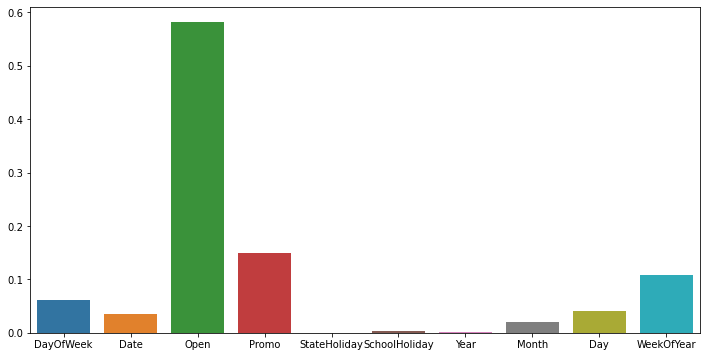

In [28]:
important_features = rfr[1].feature_importances_
plot.bar(columns, important_features)

### Serialize models

In [21]:
## use picke to dump mode
## decomment picke to save the model

reg_model_file_name = f'../models/reg-{datetime.now()}.pkl'
print(reg_model_file_name)

# pickle.dump(rf_reg, open(reg_model_file_name, 'wb'))

../models/reg-2021-07-30 09:03:46.922456.pkl


### Building model with deep learning

### Using MLFlow to serve the prediction